## Optimización de Portafolio con Acciones del IBEX 35 (2020–2024)

In [25]:
import snowflake.connector
import pandas as pd
import getpass
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


### 1. Configuración Global

In [5]:
# Configuración global
NUM_TRADING_DAYS = 252
NUM_PORTFOLIOS = 10000

# Fechas para el análisis
start_date = '2020-01-01'
end_date = '2024-12-31'

# Tickers del IBEX 35 más líquidos
stocks = ['SAN.MC', 'BBVA.MC', 'IBE.MC', 'ITX.MC', 'TEF.MC', 'REP.MC']


### 2. Conexión a Snowflake y Exploración Inicial

In [6]:

# Solicitar contraseña de forma segura
password = getpass.getpass("🔒 Introduce tu contraseña de Snowflake: ")

# Conectar a Snowflake
conn = snowflake.connector.connect(
    user='TFMGRUPO4',
    password=password,
    account='WYNIFVB-YE01854',
    warehouse='COMPUTE_WH',
    database='YAHOO_FINANCE',
    schema='MACHINE_LEARNING',
    role='ACCOUNTADMIN'
)


In [7]:

# Mostrar tickers disponibles
query_tickers = """
    SELECT DISTINCT TICKER 
    FROM TICKERS_INDEX
    ORDER BY TICKER
"""
cursor = conn.cursor()
cursor.execute(query_tickers)
available_tickers = pd.DataFrame(cursor.fetchall(), columns=[col[0] for col in cursor.description])
display(available_tickers)


,TICKER
0,0JSJ.L
1,0JYA.L
2,0K34.L
3,0RIH.L
4,0RPW.L
...,...
1348,ZIOC.L
1349,ZOO.L
1350,ZUGN.SW
1351,ZURN.SW


In [8]:
# Consulta para extraer precios
query_data = f"""
    SELECT TICKER, FECHA, CLOSE
    FROM TICKERS_INDEX
    WHERE FECHA BETWEEN '{start_date}' AND '{end_date}'
    AND TICKER IN ({','.join([f"'{s}'" for s in stocks])})
    ORDER BY FECHA
"""
cursor.execute(query_data)
df = pd.DataFrame(cursor.fetchall(), columns=[col[0] for col in cursor.description])

cursor.close()
conn.close()

df.head()

,TICKER,FECHA,CLOSE
0,IBE.MC,2020-01-02,9.220000267
1,ITX.MC,2020-01-02,31.750000000
2,REP.MC,2020-01-02,14.064999580
3,TEF.MC,2020-01-02,6.331999779
4,BBVA.MC,2020-01-02,5.110000134


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6400 entries, 0 to 6399
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   TICKER  6400 non-null   object        
 1   FECHA   6400 non-null   datetime64[ns]
 2   CLOSE   6400 non-null   object        
dtypes: datetime64[ns](1), object(2)
memory usage: 150.1+ KB


In [19]:
df['CLOSE'] = df['CLOSE'].astype(float)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6400 entries, 0 to 6399
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   TICKER  6400 non-null   object        
 1   FECHA   6400 non-null   datetime64[ns]
 2   CLOSE   6400 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 150.1+ KB


### 2. Preprocesamiento de precios y cálculo de rendimientos

In [21]:
# Pivotear para obtener precios por columna de ticker
prices = df.pivot(index='FECHA', columns='TICKER', values='CLOSE')
returns = prices.pct_change().dropna()
returns.head()

TICKER,BBVA.MC,IBE.MC,ITX.MC,REP.MC,TEF.MC
FECHA,,,,,
2020-01-03,-0.010959,-0.004555,0.001890,0.012442,0.000790
2020-01-06,-0.004353,-0.005012,-0.008802,0.007725,0.001262
2020-01-07,-0.004372,-0.019492,0.012686,-0.008362,-0.015130
2020-01-08,0.009581,0.003350,0.002192,0.009136,-0.014082
2020-01-09,0.004350,-0.017142,-0.004062,-0.013231,0.003246


### 3. Visualización de precios y rendimientos acumulados

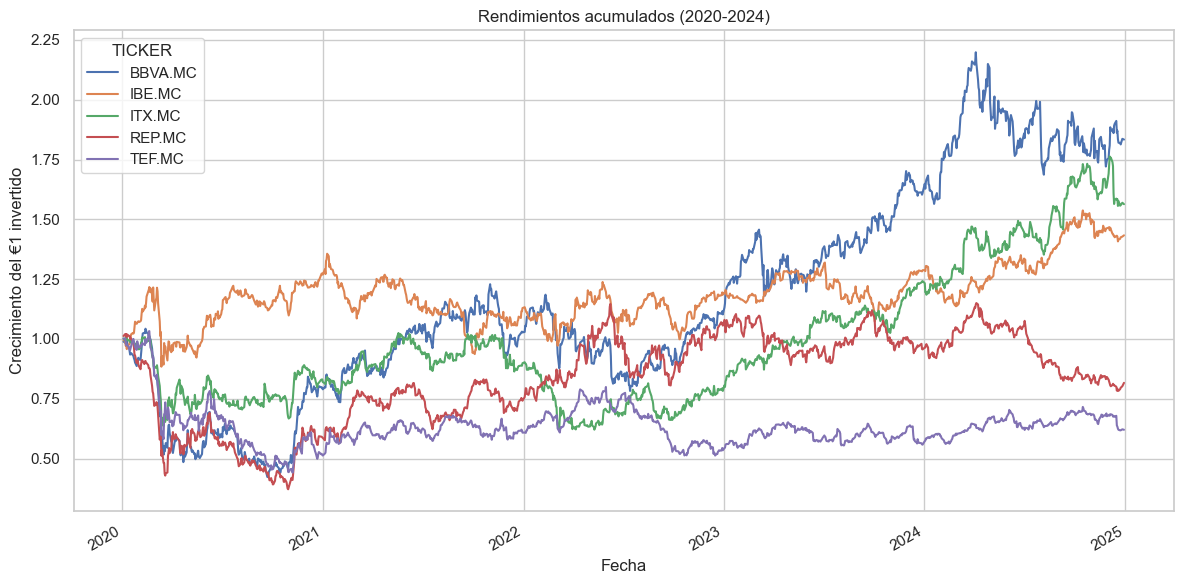

In [22]:
sns.set(style="whitegrid")
(1 + returns).cumprod().plot(figsize=(12,6), title="Rendimientos acumulados (2020-2024)")
plt.ylabel("Crecimiento del €1 invertido")
plt.xlabel("Fecha")
plt.tight_layout()
plt.show()

### 4. Portafolio Equi-Ponderado (1/n)

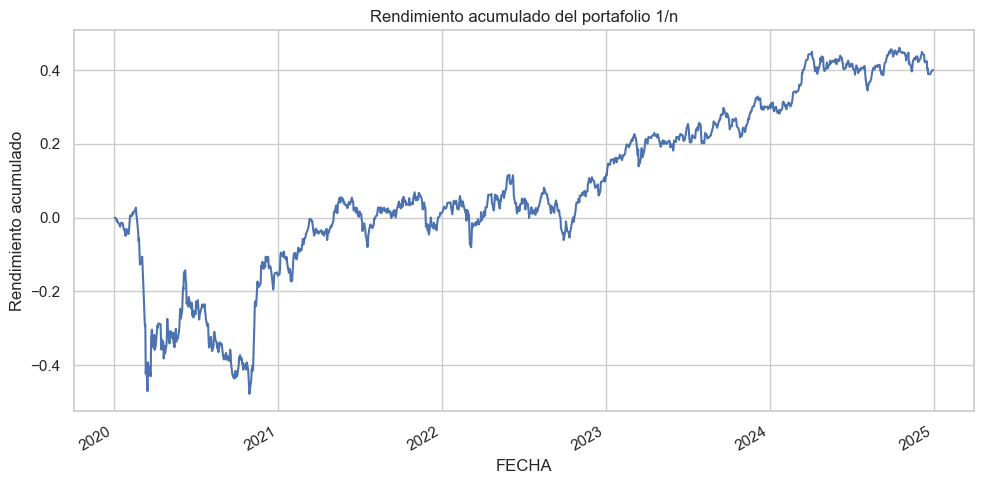

In [23]:
n_assets = len(returns.columns)
equal_weights = [1 / n_assets] * n_assets
portfolio_returns = returns.dot(equal_weights)
portfolio_returns.cumsum().plot(figsize=(10,5), title="Rendimiento acumulado del portafolio 1/n")
plt.ylabel("Rendimiento acumulado")
plt.tight_layout()
plt.show()

### 5. Simulación de Monte Carlo para la Frontera Eficiente

In [26]:

n_portfolios = 10000
mean_returns = returns.mean()
cov_matrix = returns.cov()
results = np.zeros((3, n_portfolios))
weights_record = []

for i in range(n_portfolios):
    weights = np.random.random(n_assets)
    weights /= np.sum(weights)
    weights_record.append(weights)
    portfolio_return = np.sum(mean_returns * weights)
    portfolio_stddev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = portfolio_return / portfolio_stddev
    results[0,i] = portfolio_return
    results[1,i] = portfolio_stddev
    results[2,i] = sharpe_ratio

# Crear DataFrame de resultados
results_df = pd.DataFrame({
    'Rendimiento': results[0],
    'Volatilidad': results[1],
    'Sharpe': results[2]
})
weights_df = pd.DataFrame(weights_record, columns=returns.columns)


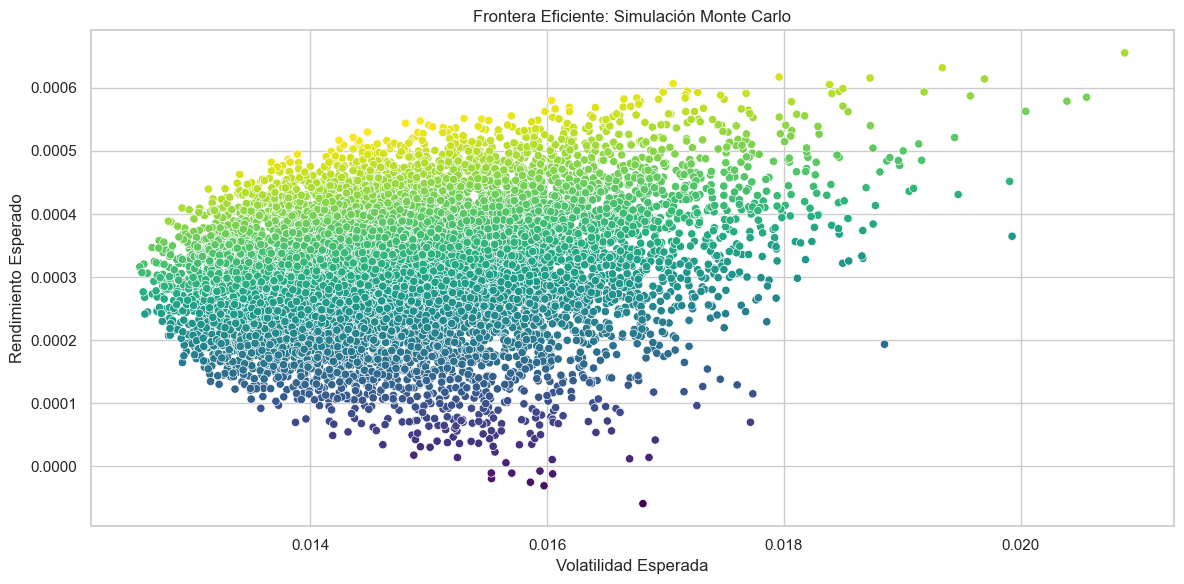

In [27]:
plt.figure(figsize=(12,6))
sns.scatterplot(data=results_df, x='Volatilidad', y='Rendimiento', hue='Sharpe', palette='viridis', legend=False)
plt.title("Frontera Eficiente: Simulación Monte Carlo")
plt.xlabel("Volatilidad Esperada")
plt.ylabel("Rendimiento Esperado")
plt.tight_layout()
plt.show()